In [ ]:
!pip install keras-tcn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tcn import TCN
from scipy.stats import shapiro


#EXPLORATORY DATA ANALYSIS

In [ ]:
df_meo1 = pd.read_csv("/kaggle/input/sih-isro-error/SIH_Data_PS-08/DATA_MEO_Train.csv")
df_meo2 = pd.read_csv("/kaggle/input/sih-isro-error/SIH_Data_PS-08/DATA_MEO_Train2.csv")
df_meo1['utc_time']=pd.to_datetime(df_meo1['utc_time'])
df_meo2['utc_time']=pd.to_datetime(df_meo2['utc_time'])
df_meo1.columns = [col.strip().replace('  ', ' ') for col in df_meo1.columns]
df_meo2.columns = [col.strip().replace('  ', ' ') for col in df_meo2.columns]
df=pd.concat([df_meo1,df_meo2], ignore_index=True)
df=df.set_index('utc_time').sort_index()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 2025-09-01 14:00:00 to 2025-09-09 11:41:00
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x_error (m)        334 non-null    float64
 1   y_error (m)        334 non-null    float64
 2   z_error (m)        334 non-null    float64
 3   satclockerror (m)  334 non-null    float64
dtypes: float64(4)
memory usage: 13.0 KB


In [ ]:
df.describe()

,x_error (m),y_error (m),z_error (m),satclockerror (m)
count,334.000000,334.000000,334.000000,334.000000
mean,-0.255814,0.065207,-0.000824,0.011321
std,0.298112,0.298535,0.362411,0.184481
min,-2.270492,-0.997851,-0.867343,-0.730753
25%,-0.422352,-0.079687,-0.136221,-0.018680
50%,-0.141376,0.038281,0.020780,-0.006356
75%,-0.064866,0.106916,0.137735,0.025990
max,0.173257,0.943559,0.926893,1.576007


In [ ]:
df.duplicated().sum()

145

In [ ]:
df=df.drop_duplicates()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189 entries, 2025-09-01 14:00:00 to 2025-09-09 11:41:00
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x_error (m)        189 non-null    float64
 1   y_error (m)        189 non-null    float64
 2   z_error (m)        189 non-null    float64
 3   satclockerror (m)  189 non-null    float64
dtypes: float64(4)
memory usage: 7.4 KB


<Axes: >

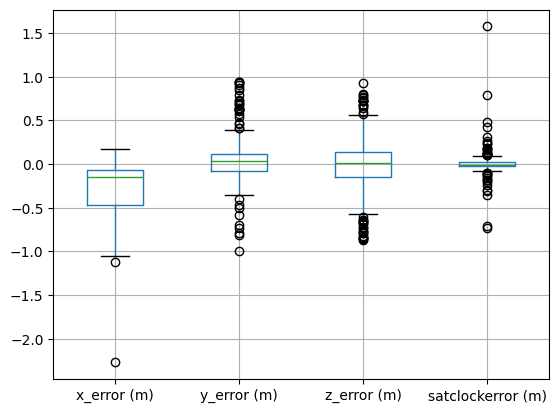

In [ ]:
df.boxplot()

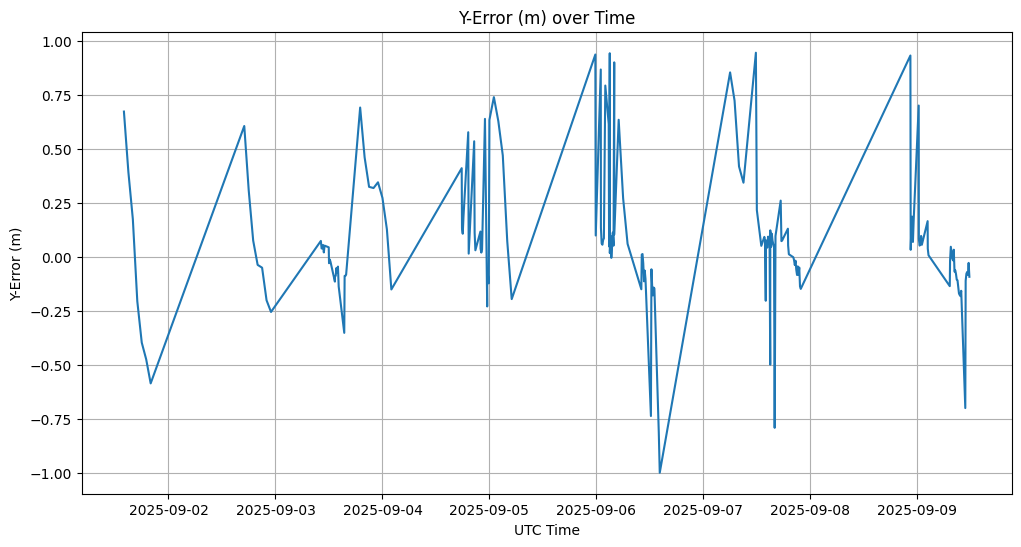

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y_error (m)'])
plt.title('Y-Error (m) over Time')
plt.xlabel('UTC Time')
plt.ylabel('Y-Error (m)')
plt.grid(True)
plt.show()

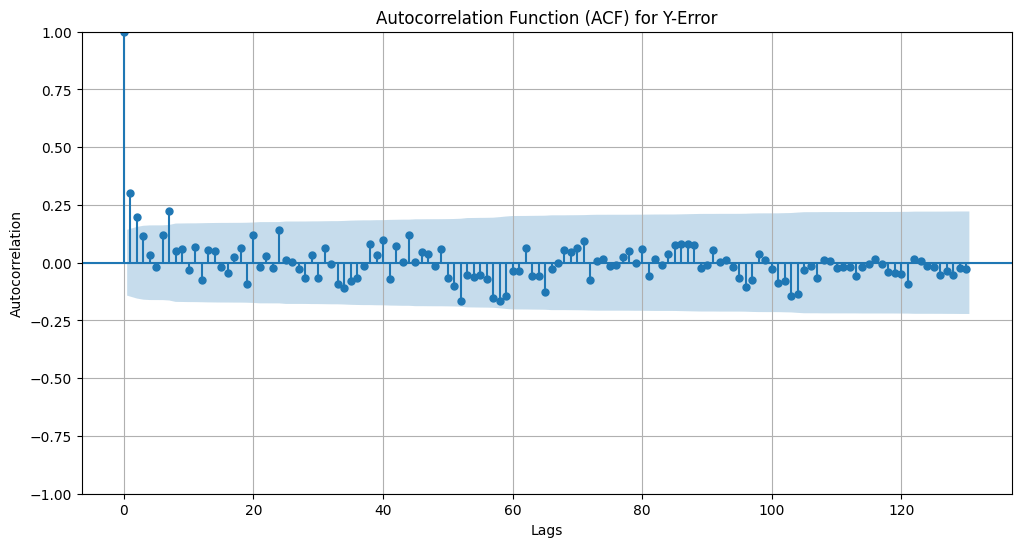

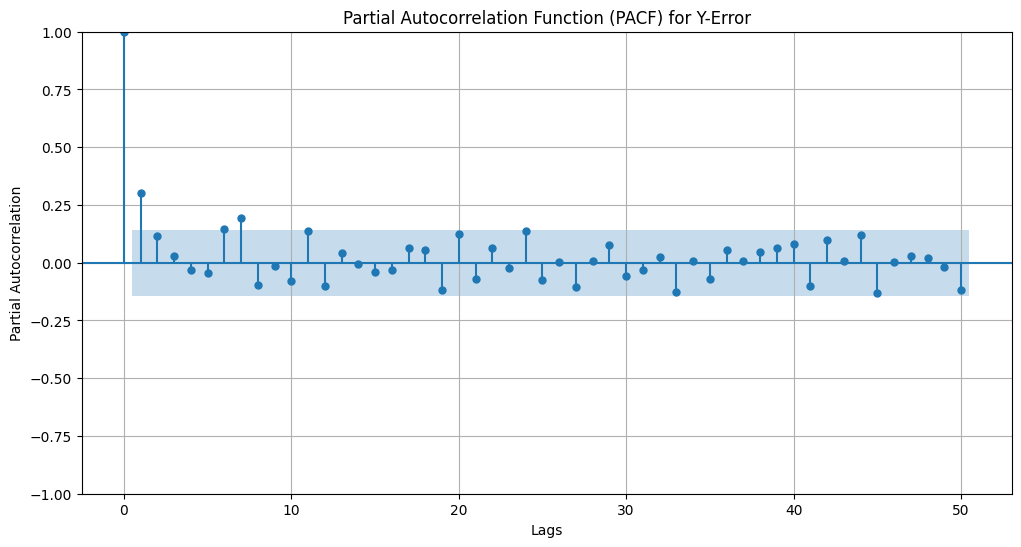

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df['y_error (m)'], lags=130, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Y-Error')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df['y_error (m)'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Y-Error')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

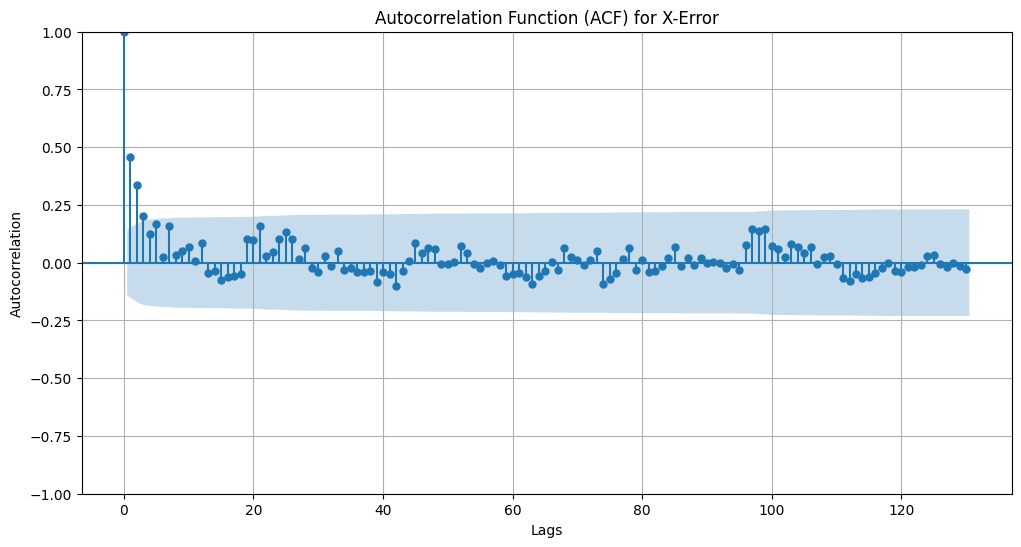

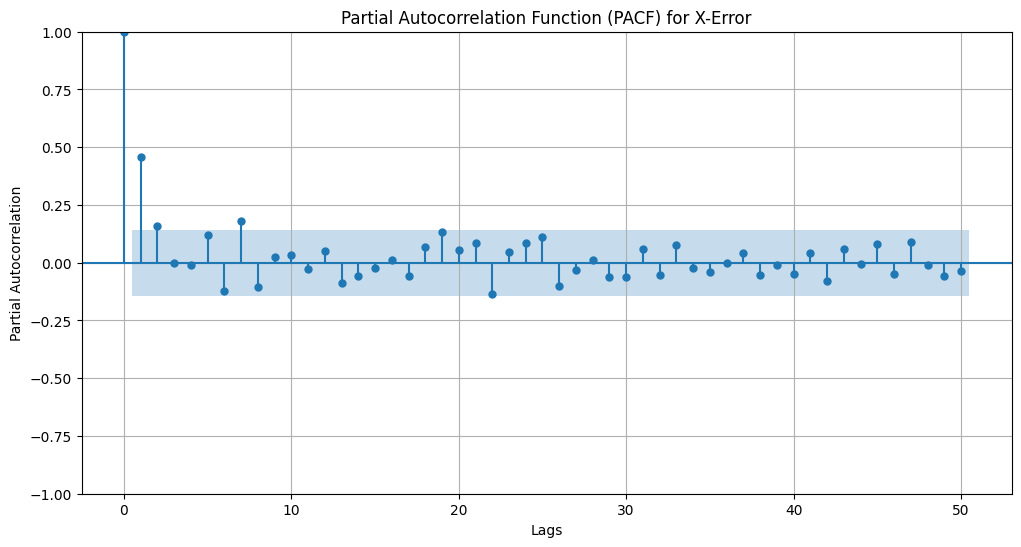

In [ ]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df['x_error (m)'], lags=130, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for X-Error')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df['x_error (m)'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for X-Error')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

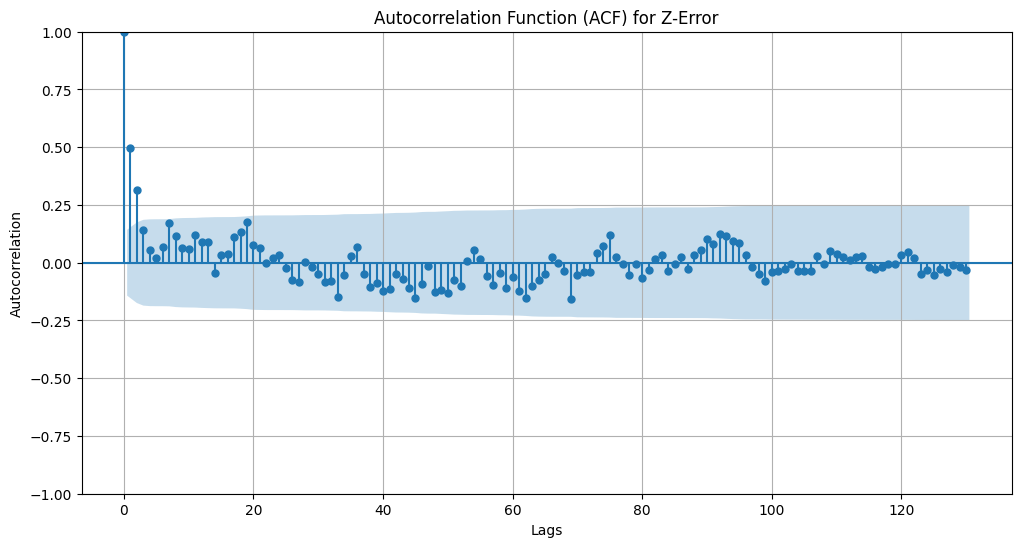

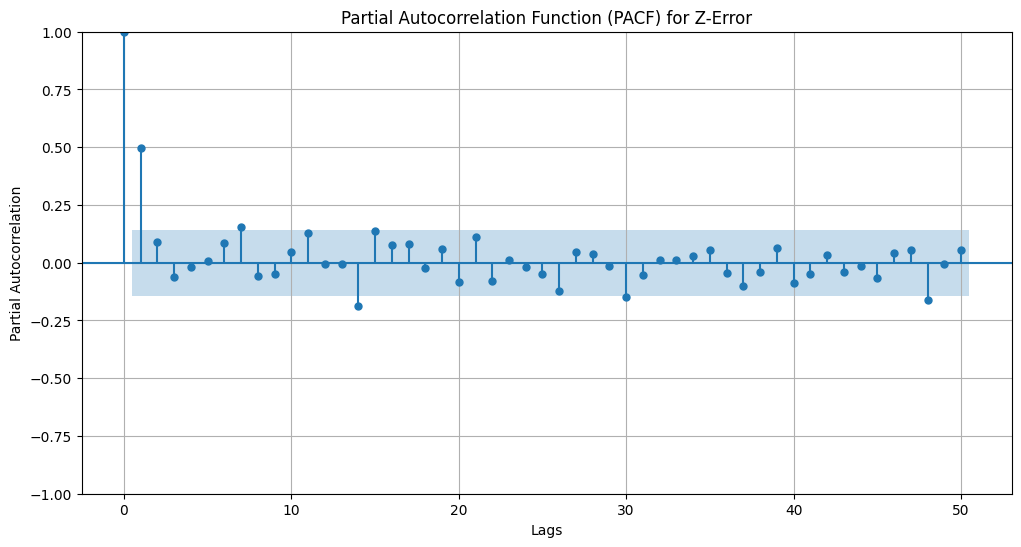

In [ ]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df['z_error (m)'], lags=130, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Z-Error')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df['z_error (m)'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Z-Error')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

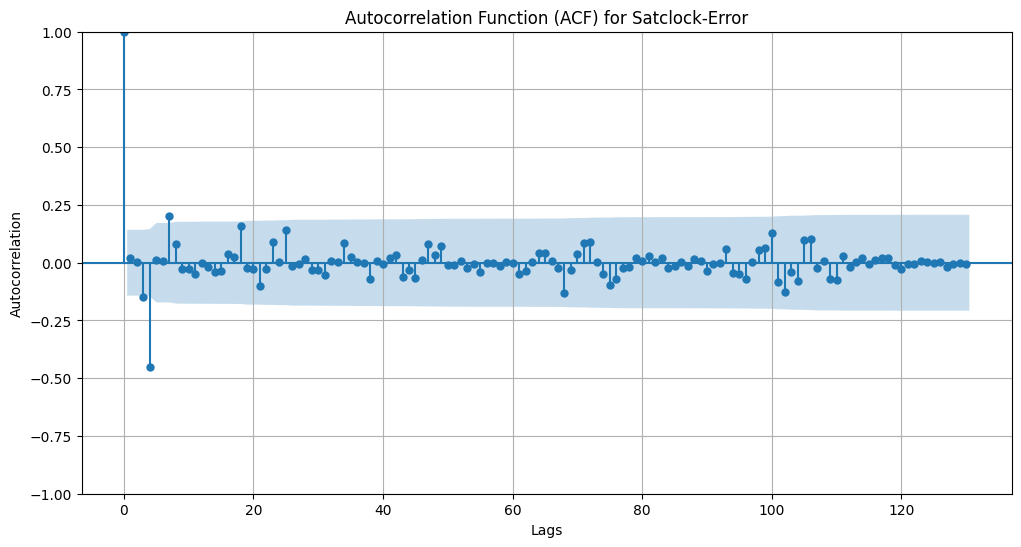

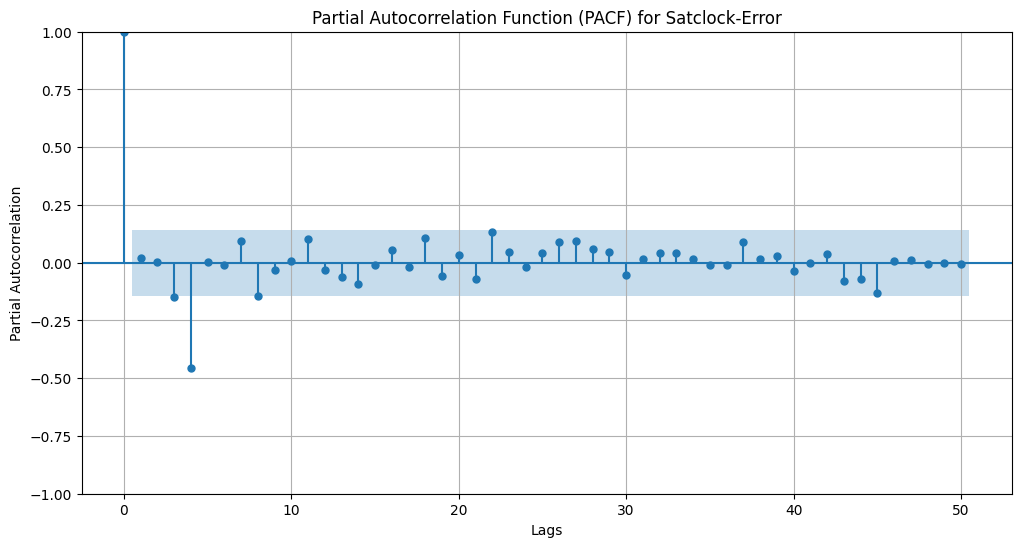

In [ ]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df['satclockerror (m)'], lags=130, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Satclock-Error')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df['satclockerror (m)'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Satclock-Error')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

<Axes: >

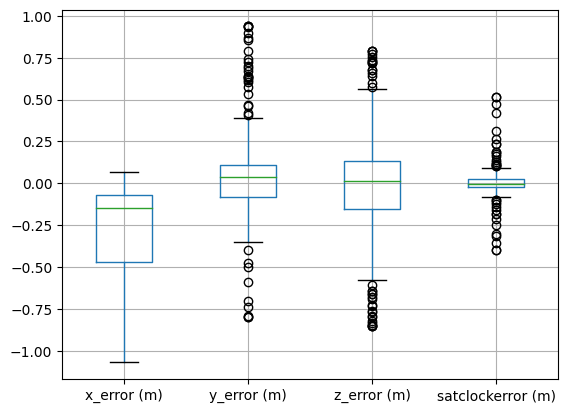

In [ ]:
df_clean=df.copy()
for cols in df.columns:
  lower=df_clean[cols].quantile(0.01)
  upper=df_clean[cols].quantile(0.99)
  df_clean[cols]=df_clean[cols].clip(lower,upper)
df_clean.boxplot()

In [ ]:
print(df_clean.shape)
df_resample=df_clean.resample('15min').interpolate(method='linear')
print(df_resample.shape)

(189, 4)
(759, 4)


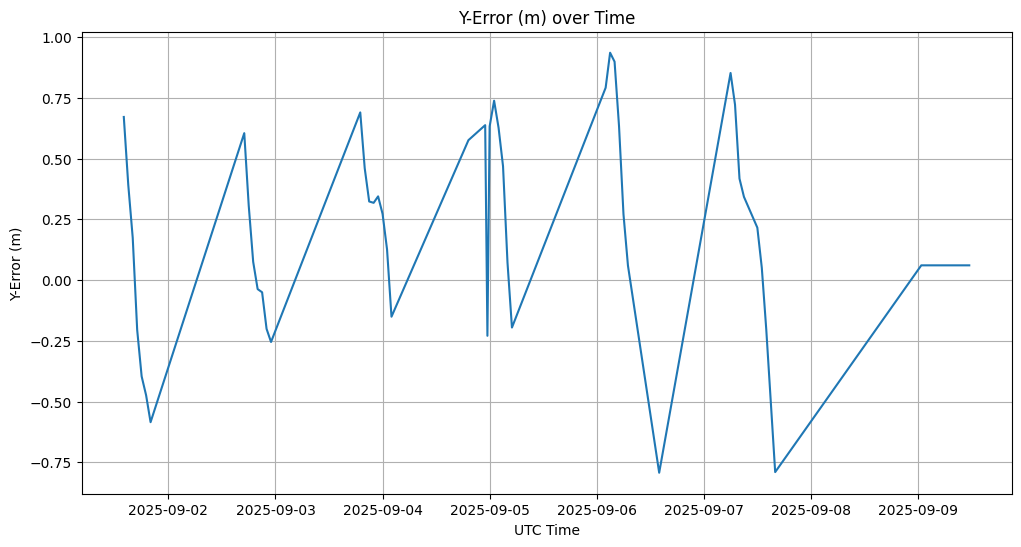

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_resample.index, df_resample['y_error (m)'])
plt.title('Y-Error (m) over Time')
plt.xlabel('UTC Time')
plt.ylabel('Y-Error (m)')
plt.grid(True)
plt.show()

In [ ]:
df_final=df_resample.copy()

In [ ]:
def engineer_advanced_features(df):
    """
    Engineers a rich set of features for the satellite error prediction task.
    Assumes the input df has a DatetimeIndex.
    """

    df_out = df.copy()

    # --- Category 2: Lag Features ---
    # We will use the original error columns for lags
    error_cols = ['x_error (m)', 'y_error (m)', 'z_error (m)', 'satclockerror (m)']

    # Lag periods are based on the 15-minute frequency
    # 1 -> 15 mins ago, 4 -> 1 hour ago, 96 -> 24 hours ago
    lag_periods = [1, 2, 4, 96]

    for col in error_cols:
        for lag in lag_periods:
            df_out[f'{col}_lag_{lag}'] = df_out[col].shift(lag)

    # --- Category 3: Rolling Window Features ---
    # Window sizes in terms of 15-min periods (4=1hr, 24=6hr, 96=24hr)
    window_sizes = [4, 24, 96]

    for col in error_cols:
        for window in window_sizes:
            # Rolling Mean
            df_out[f'{col}_roll_mean_{window}'] = df_out[col].rolling(window=window, min_periods=1).mean()
            # Rolling Standard Deviation (Volatility)
            df_out[f'{col}_roll_std_{window}'] = df_out[col].rolling(window=window, min_periods=1).std()

    # --- Category 4: Physics-Inspired Features ---
    # 10. Position Error Magnitude
    df_out['pos_error_mag'] = np.sqrt(
        df_out['x_error (m)']**2 +
        df_out['y_error (m)']**2 +
        df_out['z_error (m)']**2
    )

    # 11. Error Derivatives (Velocity and Acceleration)
    for col in error_cols:
        # Velocity
        df_out[f'{col}_vel'] = df_out[col].diff()
        # Acceleration
        df_out[f'{col}_acc'] = df_out[f'{col}_vel'].diff()


    df_out = df_out.dropna()

    return df_out

In [ ]:
df_final = engineer_advanced_features(df_final)

In [ ]:

def engineer_ultimate_features(df):
    """
    Engineers the final, most powerful set of features to address
    the 24-hour seasonality and non-stationarity.
    """
    df_out = df.copy()

    # --- Tactic 1: Supercharge Seasonality ---
    error_cols = ['x_error (m)', 'y_error (m)', 'z_error (m)', 'satclockerror (m)']

    # Create the base lag-96 feature first
    for col in error_cols:
        df_out[f'{col}_lag_96'] = df_out[col].shift(96)

    # Create the cyclical hour features
    df_out['hour_sin'] = np.sin(2 * np.pi * df_out.index.hour / 24.0)
    df_out['hour_cos'] = np.cos(2 * np.pi * df_out.index.hour / 24.0)

    # ** THE KILLER FEATURE: Interaction Term **
    # This tells the model how the 24-hour lag's importance changes by the time of day.
    for col in error_cols:
        df_out[f'{col}_lag96_x_hour_sin'] = df_out[f'{col}_lag_96'] * df_out['hour_sin']
        df_out[f'{col}_lag96_x_hour_cos'] = df_out[f'{col}_lag_96'] * df_out['hour_cos']

    # --- Tactic 2: Address Non-Stationarity ---
    # Create a linear time index
    df_out['time_idx'] = np.arange(len(df_out))
    # Scale it to be between 0 and 1
    df_out['time_idx'] = df_out['time_idx'] / len(df_out)


    df_out = df_out.dropna()

    return df_out

In [ ]:
df_final=engineer_advanced_features(df_final)

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaled_data=scaler.fit_transform(df_final)
df_geo_scaled=pd.DataFrame(scaled_data,columns=df_final.columns,index=df_final.index)
df_geo_scaled

,x_error (m),y_error (m),z_error (m),satclockerror (m),x_error (m)_lag_1,x_error (m)_lag_2,x_error (m)_lag_4,x_error (m)_lag_96,y_error (m)_lag_1,y_error (m)_lag_2,...,satclockerror (m)_roll_std_96,pos_error_mag,x_error (m)_vel,x_error (m)_acc,y_error (m)_vel,y_error (m)_acc,z_error (m)_vel,z_error (m)_acc,satclockerror (m)_vel,satclockerror (m)_acc
utc_time,,,,,,,,,,,,,,,,,,,,,
2025-09-03 14:00:00,0.054585,0.636426,0.769324,-1.597578,0.036037,0.017306,-0.015578,-0.029519,0.616148,0.595955,...,0.167553,-0.229650,0.890206,-1.110223e-16,0.452346,0.0,1.083489,2.220446e-16,-0.227002,0.000000e+00
2025-09-03 14:15:00,0.073309,0.655543,0.798337,-1.613443,0.054853,0.036213,0.003408,-0.016790,0.635230,0.615001,...,0.173846,-0.194707,0.890206,1.110223e-16,0.452346,0.0,1.083489,0.000000e+00,-0.227002,5.551115e-17
2025-09-03 14:30:00,0.092033,0.674661,0.827350,-1.629309,0.073668,0.055120,0.022394,-0.004060,0.654311,0.634047,...,0.179953,-0.158722,0.890206,0.000000e+00,0.452346,0.0,1.083489,0.000000e+00,-0.227002,-1.110223e-16
2025-09-03 14:45:00,0.110757,0.693779,0.856364,-1.645174,0.092484,0.074028,0.041381,0.008669,0.673393,0.653093,...,0.185861,-0.121767,0.890206,-1.110223e-16,0.452346,0.0,1.083489,0.000000e+00,-0.227002,1.110223e-16
2025-09-03 15:00:00,0.129480,0.712896,0.885377,-1.661040,0.111299,0.092935,0.060367,0.021399,0.692475,0.672140,...,0.191560,-0.083911,0.890206,1.110223e-16,0.452346,0.0,1.083489,0.000000e+00,-0.227002,-5.551115e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-09 10:30:00,0.464992,0.000000,-0.026342,-0.054863,0.467271,0.469549,0.476528,0.483533,0.000000,0.000000,...,-1.024525,-1.403700,-0.319634,0.000000e+00,-0.552825,0.0,0.000000,0.000000e+00,0.292477,0.000000e+00
2025-09-09 10:45:00,0.464992,0.000000,-0.026342,-0.054863,0.467271,0.469549,0.476528,0.489195,0.000000,0.000000,...,-1.032061,-1.403700,-0.319634,0.000000e+00,-0.552825,0.0,0.000000,0.000000e+00,0.292477,0.000000e+00
2025-09-09 11:00:00,0.464992,0.000000,-0.026342,-0.054863,0.467271,0.469549,0.476528,0.494858,0.000000,0.000000,...,-1.039664,-1.403700,-0.319634,0.000000e+00,-0.552825,0.0,0.000000,0.000000e+00,0.292477,0.000000e+00


In [ ]:
LOOKBACK_STEPS = 288  # 72 hours
PREDICTION_STEPS = 96 # 24 hours

TARGET_COLS = ['x_error (m)', 'y_error (m)', 'z_error (m)', 'satclockerror (m)']
target_indices = [df_geo_scaled.columns.get_loc(col) for col in TARGET_COLS]

X_samples, y_samples = [], []
data_np = df_geo_scaled.to_numpy()

for i in range(len(data_np) - LOOKBACK_STEPS - PREDICTION_STEPS + 1):
    X = data_np[i : i + LOOKBACK_STEPS]
    y = data_np[i + LOOKBACK_STEPS : i + LOOKBACK_STEPS + PREDICTION_STEPS, target_indices]
    X_samples.append(X)
    y_samples.append(y)

X_data = np.array(X_samples)
y_data = np.array(y_samples)

print("\n--- Data Sequencing Complete ---")
print(f"Number of training samples created: {X_data.shape[0]}")
print(f"Shape of input data (X): {X_data.shape}")
print(f"Shape of output data (y): {y_data.shape}")


--- Data Sequencing Complete ---
Number of training samples created: 102
Shape of input data (X): (102, 370, 53)
Shape of output data (y): (102, 96, 4)


In [ ]:
from sklearn.model_selection import train_test_split


split_index = int(len(X_data) * 0.8)

X_train = X_data[:split_index]
y_train = y_data[:split_index]

X_val = X_data[split_index:]
y_val = y_data[split_index:]

print("--- Time-Based Data Splitting Complete ---")
print("Training on the first 80% of the timeline.")
print("Validating on the last 20% of the timeline.")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

print("--- Data Splitting Complete ---")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

--- Time-Based Data Splitting Complete ---
Training on the first 80% of the timeline.
Validating on the last 20% of the timeline.
X_train shape: (147, 288, 53)
X_val shape: (37, 288, 53)
--- Data Splitting Complete ---
X_train shape: (147, 288, 53)
y_train shape: (147, 96, 4)
X_val shape: (37, 288, 53)
y_val shape: (37, 96, 4)


In [ ]:

n_features = X_train.shape[2]
n_timesteps_in = X_train.shape[1]
n_timesteps_out = y_train.shape[1]
n_outputs = y_train.shape[2]


In [ ]:

DROPOUT_RATE = 0.1

tcn_model = Sequential([
    # --- Encoder ---
    # The TCN layer acts as the encoder. return_sequences=False creates the summary vector.

    TCN(
        nb_filters=256, # Number of convolutional filters
        kernel_size=3, # The size of the convolution window
        dilations=[1, 2, 4, 8, 16], # The dilation rates, defines the receptive field
        return_sequences=True,
        input_shape=(n_timesteps_in, n_features),

    ),
    Dropout(DROPOUT_RATE),
    TCN(
        nb_filters=128, # Number of convolutional filters
        kernel_size=3, # The size of the convolution window
        dilations=[1, 2, 4, 8, 16], # The dilation rates, defines the receptive field
        return_sequences=False,
        input_shape=(n_timesteps_in, n_features),

    ),
    Dropout(DROPOUT_RATE),

    # --- Bridge  ---
    tf.keras.layers.RepeatVector(n_timesteps_out),

    # --- Decoder ---
    # A second TCN layer acts as the decoder. return_sequences=True generates the output sequence.
    TCN(
        nb_filters=128,
        kernel_size=3,
        dilations=[1, 2, 4, 8, 16],
        return_sequences=True,

    ),
    Dropout(DROPOUT_RATE),

    # --- Output Layer ---
    tf.keras.layers.TimeDistributed(Dense(n_outputs))
])

tcn_model.summary()

/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_40 (TCN)                    │ (None, 288, 256)       │     1,826,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 288, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_41 (TCN)                    │ (None, 128)            │       574,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_12 (RepeatVector) │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_42 (TCN)                    │ (None, 96, 128)        │       492,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 96, 4)          │           516 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,894,724 (11.04 MB)

 Trainable params: 2,894,724 (11.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
loss=tf.keras.losses.Huber()
tcn_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['mae', 'mse']
)

print("\n--- TCN Model Compilation Complete ---")


# --- Train the TCN model ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
tcn_history = tcn_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[ lr_scheduler]
)

print("\n--- TCN Model Training Complete ---")


--- TCN Model Compilation Complete ---
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 69s 12s/step - loss: 1574.3591 - mae: 1574.8589 - mse: 6750615.5000 - val_loss: 30.2302 - val_mae: 30.7260 - val_mse: 1330.4801 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 25.0305 - mae: 25.5241 - mse: 1351.7611 - val_loss: 2.0187 - val_mae: 2.4786 - val_mse: 9.3459 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 3.3551 - mae: 3.8219 - mse: 27.1189 - val_loss: 0.3579 - val_mae: 0.7219 - val_mse: 0.8303 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.8749 - mae: 1.2885 - mse: 2.8772 - val_loss: 0.0848 - val_mae: 0.3304 - val_mse: 0.1700 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.3853 - mae: 0.7536 - mse: 0.8930 - val_loss: 0.1112 - val_mae: 0.3749 - val_mse: 0.2241 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.2775 - mae: 0.6228

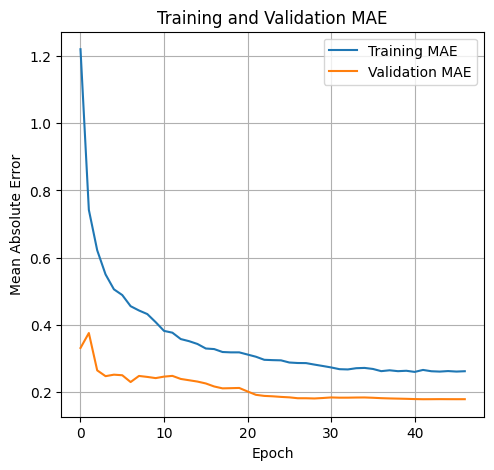

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting MAE
plt.subplot(1, 2, 1)
plt.plot(tcn_history.history['mae'][3:], label='Training MAE')
plt.plot(tcn_history.history['val_mae'][3:], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)


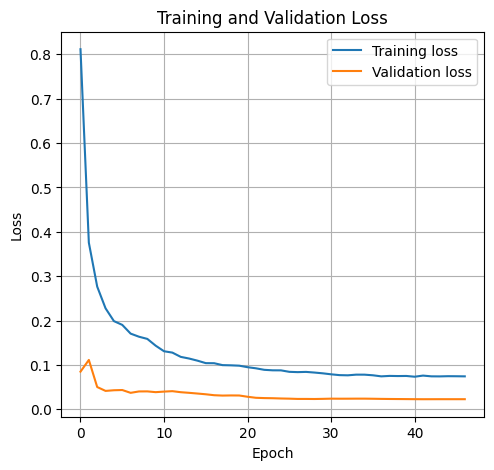

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting MAE
plt.subplot(1, 2, 1)
plt.plot(tcn_history.history['loss'][3:], label='Training loss')
plt.plot(tcn_history.history['val_loss'][3:], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

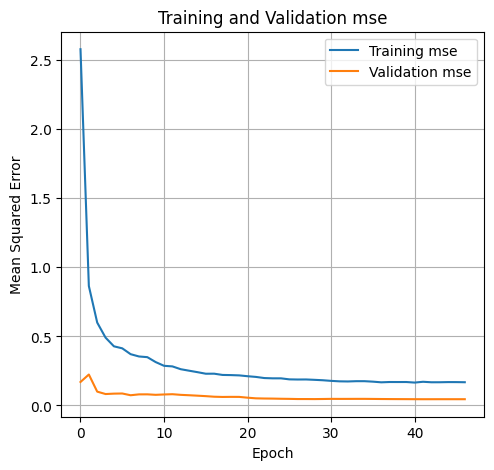

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting MAE
plt.subplot(1, 2, 1)
plt.plot(tcn_history.history['mse'][3:], label='Training mse')
plt.plot(tcn_history.history['val_mse'][3:], label='Validation mse')
plt.title('Training and Validation mse')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

In [ ]:
predictions_scaled = tcn_model.predict(X_val)
n_features = scaler.n_features_in_

# Reshape the predictions to be 2D
predictions_reshaped = predictions_scaled.reshape(-1, predictions_scaled.shape[-1])



# Create the dummy array
dummy_array = np.zeros((predictions_reshaped.shape[0], n_features))

# Place our predictions into the first 4 columns of the dummy array
dummy_array[:, :predictions_scaled.shape[-1]] = predictions_reshaped

# Now, inverse-transform the entire dummy array
unscaled_full_array = scaler.inverse_transform(dummy_array)

# Extract just our unscaled predictions (the first 4 columns)
predictions_unscaled = unscaled_full_array[:, :predictions_scaled.shape[-1]]

# Reshape back to the original 3D format (num_samples, 96, 4)
predictions_final = predictions_unscaled.reshape(predictions_scaled.shape)

# We also need to unscale the true values (y_val) for comparison
y_val_unscaled = scaler.inverse_transform(
    np.hstack([
        y_val.reshape(-1, y_val.shape[-1]),
        np.zeros((y_val.shape[0] * y_val.shape[1], n_features - y_val.shape[2]))
    ])
)[:, :y_val.shape[-1]].reshape(y_val.shape)


print("--- Predictions have been unscaled back to meters ---")
print("Shape of final predictions:", predictions_final.shape)
print("Example of a predicted first step for the first validation sample:")
print(predictions_final[0, 0, :])

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step
--- Predictions have been unscaled back to meters ---
Shape of final predictions: (37, 96, 4)
Example of a predicted first step for the first validation sample:
[-0.26539202 -0.22767152  0.14158706  0.12702194]


In [ ]:
final_input_data = df_final.tail(LOOKBACK_STEPS)
final_input_scaled = scaler.transform(final_input_data)
final_input_reshaped = np.expand_dims(final_input_scaled, axis=0)

# The output will have a shape of (1, 96, 4)

# Get the 2D array from the 3D output, shape (96, 4)
prediction_scaled_2d = predictions_scaled[0]

n_features = scaler.n_features_in_

# Create a dummy array with the correct shape (96, num_features)
dummy_array = np.zeros((prediction_scaled_2d.shape[0], n_features))

# Place our 2D predictions into the first 4 columns of the dummy array
dummy_array[:, :prediction_scaled_2d.shape[1]] = prediction_scaled_2d

# Now, inverse-transform the entire dummy array
unscaled_full_array = scaler.inverse_transform(dummy_array)

# Extract just our unscaled predictions (the first 4 columns)
predictions_unscaled = unscaled_full_array[:, :prediction_scaled_2d.shape[1]]

# `predictions_unscaled` is now a clean (96, 4) NumPy array with values in meters.

last_timestamp = final_input_data.index[-1]
prediction_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(minutes=15), periods=96, freq='15T')

target_names = ['x_error_predicted (m)', 'y_error_predicted (m)', 'z_error_predicted (m)', 'satclock_error_predicted (m)']
predictions_df = pd.DataFrame(data=predictions_unscaled, index=prediction_timestamps, columns=target_names)
predictions_df.index.name = 'utc_time'

print("\n--- Final Predictions for the 8th Day ---")
print(predictions_df.head())

predictions_df.to_csv('final_predictions_day_8.csv')

print("\nSuccessfully saved the final predictions to 'final_predictions_day_8.csv'")


--- Final Predictions for the 8th Day ---
                     x_error_predicted (m)  y_error_predicted (m)  \
utc_time                                                            
2025-09-09 11:45:00              -0.265392              -0.227672   
2025-09-09 12:00:00              -0.286860              -0.229324   
2025-09-09 12:15:00              -0.279430              -0.271957   
2025-09-09 12:30:00              -0.288519              -0.301307   
2025-09-09 12:45:00              -0.271501              -0.360401   

                     z_error_predicted (m)  satclock_error_predicted (m)  
utc_time                                                                  
2025-09-09 11:45:00               0.141587                      0.127022  
2025-09-09 12:00:00               0.133438                      0.127322  
2025-09-09 12:15:00               0.175983                      0.126970  
2025-09-09 12:30:00               0.146744                      0.144200  
2025-09-09 12:45:00    

/tmp/ipykernel_37/2914832299.py:30: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  prediction_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(minutes=15), periods=96, freq='15T')



--- Shapiro-Wilk Normality Test on Residuals ---
Statistic: 0.9857173437
P-value: 0.00000000000000000000000000000000003111064653047230

The residuals do NOT look Normally Distributed (reject H0).


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14208.
  res = hypotest_fun_out(*samples, **kwds)


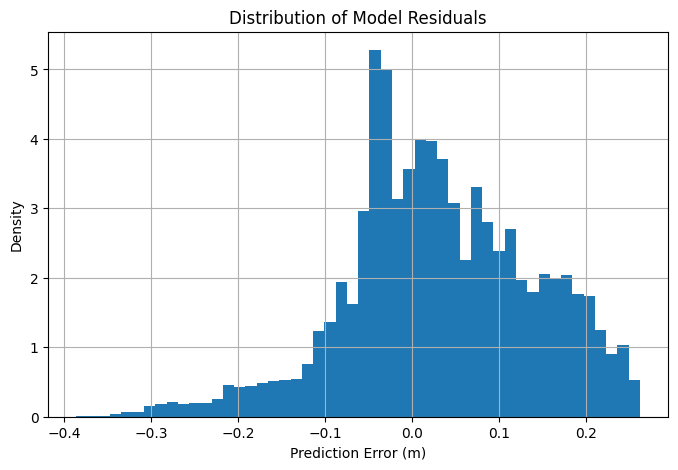

In [ ]:
from scipy.stats import shapiro

# --- Calculate the residuals ---
residuals = y_val_unscaled - predictions_final

# The residuals array has the shape (num_samples, 96, 4).
# We need to flatten it to a 1D array for the Shapiro-Wilk test.
residuals_flat = residuals.flatten()


stat, p_value = shapiro(residuals_flat)

print("\n--- Shapiro-Wilk Normality Test on Residuals ---")
print(f"Statistic: {stat:.10f}")
print(f"P-value: {p_value:.50f}")


alpha = 0.05
if p_value > alpha:
    print("\nThe residuals look Normally Distributed (fail to reject H0).")
    print("This is a GREAT result for your model!")
else:
    print("\nThe residuals do NOT look Normally Distributed (reject H0).")

plt.figure(figsize=(8, 5))
plt.hist(residuals_flat, bins=50, density=True)
plt.title('Distribution of Model Residuals')
plt.xlabel('Prediction Error (m)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

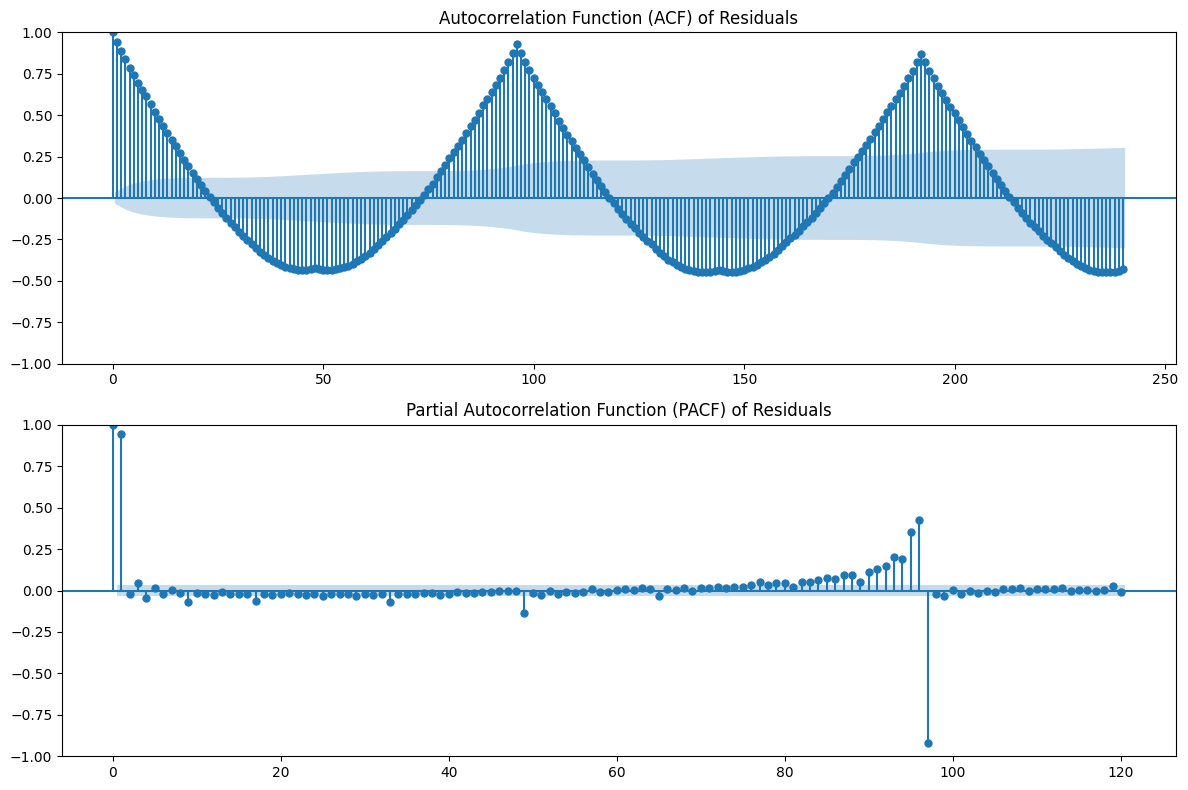

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


residuals_y_error = (y_val_unscaled - predictions_final)[:, :, 1].flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF
plot_acf(residuals_y_error, lags=240, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) of Residuals')

# Plot PACF
plot_pacf(residuals_y_error, lags=120, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) of Residuals')

plt.tight_layout()
plt.show()

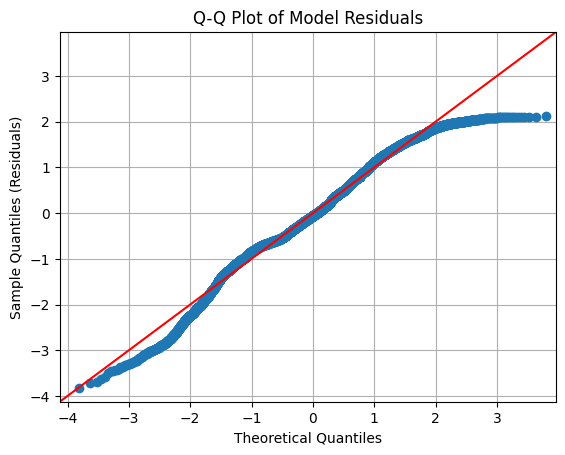

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt



if 'residuals_flat' in locals():

    # Create the Q-Q plot
    fig = sm.qqplot(
        residuals_flat,
        line='45',
        fit=True
    )

    plt.title("Q-Q Plot of Model Residuals")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles (Residuals)")
    plt.grid(True)
    plt.show()

else:
    print("Please ensure your 'residuals_flat' array is calculated and available.")